### Importing packages

In [1]:
import pandas as pd
import networkx as nx
import numpy as np

import random
%matplotlib inline
#%config InlineBackend.figure_formats = ['retina']

import seaborn as sns

import matplotlib.pyplot as plt
import math
import json
import datetime

from collections import defaultdict

import dask
import dask.dataframe as dd
from dask import threaded, multiprocessing
number_of_process = 4

from scipy.stats import poisson
import soil
from soil.analysis import *

from dask import delayed
import dask.dataframe as dd
import dask
import os.path
import dask.bag as db

import logging

sns.set()
sns.set_context('paper')

In [75]:
import pickle

def save_obj(obj, name):
    with open('datasets/Weibo/obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('datasets/Weibo/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Reading Data and Preprocessing 

Creating following dictionarry for quick access the neighbors in future programming

In [22]:
%%time
following = {}
with open('datasets/Weibo/weibo_network.txt') as file:    
    line = file.readline()
    line = file.readline()
    while(line):
        values = line.split()
        node = int(values[0])
        for i in range(2, len(values), 2):
            following.setdefault(node, set()).add(int(values[i]))
        line = file.readline()

CPU times: user 23min 35s, sys: 2min 46s, total: 26min 22s
Wall time: 26min 20s


In [25]:
#save_obj(followedBy, "following_dict")

In [19]:
%%time
following = load_obj('following_dict')

CPU times: user 4min 28s, sys: 1min 49s, total: 6min 18s
Wall time: 6min 19s


In [44]:
%%time
postid = []

with open('datasets/Weibo/repost_idlist.txt') as file:
    id = 0
    line = file.readline()
    
    while(line):
        postid.append([id, line.split()[0]])
        id += 1
        line = file.readline()        

CPU times: user 47.5 s, sys: 32.7 s, total: 1min 20s
Wall time: 1min 19s


In [39]:
len(postid)

300000

In [46]:
posts = pd.DataFrame(postid, columns=['id', 'original_id'])

In [54]:
len(posts)

300000

In [52]:
%%time
data = []
with open('datasets/Weibo/total.txt') as file:
    line = file.readline()
    
    while(line):
        data.append(line.split())        
        line = file.readline()
        line = file.readline()

CPU times: user 3.8 s, sys: 1.4 s, total: 5.2 s
Wall time: 5.21 s


In [57]:
posts_user = pd.DataFrame(data, columns=['original_id', 'time', 'user_id', 'number_of_repost'])

In [58]:
posts_user.head()

original_id                 time  user_id number_of_repost
0  3479380645050771  2012-08-15-20:07:32  1500872                3
1  3464585309142627  2012-07-06-00:16:10   153602              595
2  3463921564867182  2012-07-04-04:18:39   519514             3167
3  3453196284937865  2012-06-04-14:00:14   490872             3255
4  3514161490841646  2012-11-19-19:34:09  1501242               17

In [59]:
posts_with_data = posts.merge(posts_user, on='original_id', how='inner')

In [61]:
posts_with_data.head()

id       original_id                 time  user_id number_of_repost
0   4  3489066345635304  2012-09-11-13:35:01   519514             8662
1   5  3351668017021965  2011-08-29-10:03:09  1655794             7700
2   6  3431265414323641  2012-04-05-01:34:47  1781674                3
3   7  3505167934357357  2012-10-25-23:57:01   486193               14
4   8  3379316700965109  2011-11-13-17:09:09       92                3

In [62]:
posts_with_data['ts'] = pd.to_datetime(posts_with_data.time)

In [65]:
posts_with_data.sort_values(by='ts', inplace=True)

In [66]:
posts_with_data.head()

id    original_id                 time  user_id number_of_repost  \
223404  287214  1090828206622  2009-08-28-10:51:11    66930               19   
43176    53429  1090830266724  2009-08-30-19:43:46   235615              107   
46148    57184  1090904131282  2009-09-04-10:43:32    50456                1   
2353      2853  1090908316096  2009-09-08-13:36:47   806063                1   
93134   116515  1090912533988  2009-09-12-12:39:15  1485897              113   

                        ts  
223404 2009-08-28 10:51:11  
43176  2009-08-30 19:43:46  
46148  2009-09-04 10:43:32  
2353   2009-09-08 13:36:47  
93134  2009-09-12 12:39:15

In [79]:
posts_with_data['date'] = posts_with_data.ts.dt.date

In [86]:
posts_with_data['month'] = posts_with_data.ts.dt.month

In [98]:
posts_with_data['year'] = posts_with_data.ts.dt.year

In [101]:
#posts_with_data.to_csv('datasets/Weibo/tweet_with_details.csv')

In [5]:
posts_with_data = pd.read_csv('datasets/Weibo/tweet_with_details.csv', index_col=0, dtype={'id': int})

In [8]:
%%time
data = []
count = 0
whilec = 0
with open('datasets/Weibo/repost_data.txt') as file:
    line = file.readline()
    while(line):
        whilec+=1
        d = line.split()
        parent_id = posts_with_data[posts_with_data.id == int(d[0])].user_id.values
        if(len(parent_id) == 0):
            count += 1
            for i in range(int(d[1])):
                line = file.readline()
        else:            
            for i in range(int(d[1])):
                line = file.readline()
                fd = line.split()            
                data.append([int(d[0]), fd[0], fd[1], parent_id[0]])            
        line = file.readline()
        if(whilec % 100000 == 0):
            print(whilec)
        


100000
200000
300000
CPU times: user 17min 29s, sys: 49 s, total: 18min 18s
Wall time: 18min 18s


In [120]:
data[0:4]

[[4, '1347341701', '519514', '519514'],
 [4, '1347341744', '1065458', '519514'],
 [4, '1347341788', '633675', '519514'],
 [4, '1347341817', '872097', '519514']]

In [9]:
retweets = pd.DataFrame(data, columns=['postid', 'ts', 'user_id', 'parent_user_id'])

In [30]:
#retweets.to_csv('datasets/Weibo/retweets.csv')
retweets = pd.read_csv('datasets/Weibo/retweets.csv', index_col=0, dtype={'user_id': int, 'parent_user_id':int, })

In [130]:
from datetime import datetime
datetime.fromtimestamp(1347341701)

datetime.datetime(2012, 9, 11, 5, 35, 1)

In [23]:
retweets.dtypes

postid                     int64
ts                         int64
user_id                    int64
parent_user_id             int64
ts_hr             datetime64[ns]
dtype: object

In [19]:
len(retweets[retweets.user_id == retweets.parent_user_id])

232978

In [24]:
retweets['ts_hr'] = pd.to_datetime(retweets.ts, unit='s')

In [25]:
retweets.head()

postid          ts  user_id  parent_user_id               ts_hr
0       4  1347341701   519514          519514 2012-09-11 05:35:01
1       4  1347341744  1065458          519514 2012-09-11 05:35:44
2       4  1347341788   633675          519514 2012-09-11 05:36:28
3       4  1347341817   872097          519514 2012-09-11 05:36:57
4       4  1347341818   318923          519514 2012-09-11 05:36:58

In [27]:
retweets['date'] = retweets.ts_hr.dt.date
retweets['month'] = retweets.ts_hr.dt.month
retweets['year'] = retweets.ts_hr.dt.year

In [31]:
retweets.head()

postid          ts  user_id  parent_user_id               ts_hr  \
0       4  1347341701   519514          519514 2012-09-11 05:35:01   
1       4  1347341744  1065458          519514 2012-09-11 05:35:44   
2       4  1347341788   633675          519514 2012-09-11 05:36:28   
3       4  1347341817   872097          519514 2012-09-11 05:36:57   
4       4  1347341818   318923          519514 2012-09-11 05:36:58   

         date  month  year  
0  2012-09-11      9  2012  
1  2012-09-11      9  2012  
2  2012-09-11      9  2012  
3  2012-09-11      9  2012  
4  2012-09-11      9  2012

In [32]:
%%time

retweet2012 = retweets[retweets.year == 2012].copy()
retweet2011 = retweets[retweets.year == 2011].copy()
retweet2010 = retweets[retweets.year == 2010].copy()
retweet2009 = retweets[retweets.year == 2009].copy()

#retweet2012.to_csv('datasets/Weibo/retweet2012.csv')
#retweet2011.to_csv('datasets/Weibo/retweet2011.csv')
#retweet2010.to_csv('datasets/Weibo/retweet2010.csv')
#retweet2009.to_csv('datasets/Weibo/retweet2009.csv')

CPU times: user 18min 36s, sys: 15.7 s, total: 18min 52s
Wall time: 18min 59s


In [4]:
retweet2011 = pd.read_csv('datasets/Weibo/retweet2011.csv', index_col=0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [21]:
retweet2011.head()

postid          ts  user_id  parent_user_id                ts_hr  \
274       5  1314583389  1655794         1655794  2011-08-29 02:03:09   
275       5  1314584598   633978         1655794  2011-08-29 02:23:18   
276       5  1314586347  1685591         1655794  2011-08-29 02:52:27   
277       5  1314586515  1124893         1655794  2011-08-29 02:55:15   
278       5  1314586557   324236         1655794  2011-08-29 02:55:57   

           date  month  year  
274  2011-08-29      8  2011  
275  2011-08-29      8  2011  
276  2011-08-29      8  2011  
277  2011-08-29      8  2011  
278  2011-08-29      8  2011

In [22]:
retweet2011monthly = retweet2011.groupby(by=['month', 'user_id']).count()

In [23]:
retweet2011monthly.reset_index(inplace=True)

In [24]:
retweet2011monthly.head()

month  user_id  postid  ts  parent_user_id  ts_hr  date  year
0      1        1       1   1               1      1     1     1
1      1       13       2   2               2      2     2     2
2      1       34       1   1               1      1     1     1
3      1       59       1   1               1      1     1     1
4      1       71       1   1               1      1     1     1

In [25]:
retweet2011monthly.drop(columns=['ts', 'parent_user_id', 'ts_hr', 'date', 'year'], inplace=True)

In [26]:
retweet2011monthly.rename(columns={'postid':'post_count'}, inplace=True)

In [27]:
retweet2011monthly_kn = retweet2011[retweet2011.user_id != retweet2011.parent_user_id].groupby(by=['month', 'user_id']).count()

In [28]:
retweet2011monthly_kn.reset_index(inplace=True)

In [29]:
retweet2011monthly_kn.head()

month  user_id  postid  ts  parent_user_id  ts_hr  date  year
0      1        1       1   1               1      1     1     1
1      1       13       2   2               2      2     2     2
2      1       34       1   1               1      1     1     1
3      1       59       1   1               1      1     1     1
4      1       91       4   4               4      4     4     4

In [30]:
retweet2011monthly_kn.drop(columns=['ts', 'parent_user_id', 'ts_hr', 'date', 'year'], inplace=True)
retweet2011monthly_kn.rename(columns={'postid':'post_kn_count'}, inplace=True)

In [31]:
retweet2011m_all = retweet2011monthly.merge(retweet2011monthly_kn, on=['month', 'user_id'], how='left')

In [32]:
len(retweet2011m_all)

3104291

In [33]:
retweet2011m_all.head()

month  user_id  post_count  post_kn_count
0      1        1           1            1.0
1      1       13           2            2.0
2      1       34           1            1.0
3      1       59           1            1.0
4      1       71           1            NaN

In [34]:
retweet2011m_all.post_kn_count.fillna(0, inplace=True)

In [72]:
%%time
data = []
for key, value in following.items():
    for itm in value:
        data.append([key, itm])

following_edges = pd.DataFrame(data, columns=['user_id', 'following'])

CPU times: user 37min 28s, sys: 26min 11s, total: 1h 3min 39s
Wall time: 1h 3min 23s


In [74]:
len(following_edges)

413503687

In [75]:
#following_edges.to_csv('datasets/Weibo/following.csv')

In [131]:
%%time
following_edges = pd.read_csv('datasets/Weibo/following.csv')

CPU times: user 6min 7s, sys: 42.1 s, total: 6min 49s
Wall time: 6min 51s


In [132]:
following_edges.head()

Unnamed: 0  user_id  following
0           0        0     153602
1           1        0     882691
2           2        0    1221123
3           3        0          3
4           4        0     868871

In [138]:
len(followers)

1047629

In [140]:
%%time
followers = {}
for key, value in following.items():
    v = int(key)
    for n in value:
        node = int(n)
        followers.setdefault(node, set()).add(v)

CPU times: user 22min 50s, sys: 4min 53s, total: 27min 44s
Wall time: 27min 44s


In [143]:
#save_obj(followers, 'followers_dict')

In [76]:
%%time
followers = load_obj('followers_dict')

CPU times: user 3min 30s, sys: 1min 22s, total: 4min 53s
Wall time: 4min 52s


In [88]:
retweet2011m_all.head()

month  user_id  post_count  post_kn_count
0      1        1           1            1.0
1      1       13           2            2.0
2      1       34           1            1.0
3      1       59           1            1.0
4      1       71           1            0.0

In [90]:
retweet2011.head()

postid          ts  user_id  parent_user_id               ts_hr  \
274       5  1314583389  1655794         1655794 2011-08-29 02:03:09   
275       5  1314584598   633978         1655794 2011-08-29 02:23:18   
276       5  1314586347  1685591         1655794 2011-08-29 02:52:27   
277       5  1314586515  1124893         1655794 2011-08-29 02:55:15   
278       5  1314586557   324236         1655794 2011-08-29 02:55:57   

           date  month  year  
274  2011-08-29      8  2011  
275  2011-08-29      8  2011  
276  2011-08-29      8  2011  
277  2011-08-29      8  2011  
278  2011-08-29      8  2011

In [64]:
len(retweet2011m_all)

3104291

In [46]:
retweet2011m_all.head()

month  user_id  post_count  post_kn_count
0      1        1           1            1.0
1      1       13           2            2.0
2      1       34           1            1.0
3      1       59           1            1.0
4      1       71           1            0.0

In [37]:
def getTotalPulse(row):
    user_id = row.user_id
    month = row.month
    
    try:
        months_tweets = retweet2011[(retweet2011.month == month)]
        neighbors = pd.DataFrame(list(following[user_id]), columns=['following'])
        return len(months_tweets.merge(neighbors, left_on='user_id', right_on='following', how='inner'))
    except:
        return -1

In [45]:
retweet2011[retweet2011.month == 1].sort_values(by='ts').head()

postid          ts  user_id  parent_user_id                ts_hr  \
28614937  212804  1293840028   894297          595921  2011-01-01 00:00:28   
30418028  263822  1293840365   281115          955707  2011-01-01 00:06:05   
4534959    16570  1293840403   446845          978003  2011-01-01 00:06:43   
30973528  282121  1293840760   911220          838445  2011-01-01 00:12:40   
837693      3000  1293840882  1219255          491496  2011-01-01 00:14:42   

                date  month  year  
28614937  2011-01-01      1  2011  
30418028  2011-01-01      1  2011  
4534959   2011-01-01      1  2011  
30973528  2011-01-01      1  2011  
837693    2011-01-01      1  2011

In [61]:
months_tweets = retweet2011m_all[(retweet2011m_all.month == month)]
neighbors = pd.DataFrame(list(following[user_id]), columns=['following'])
print(months_tweets.merge(neighbors, left_on='user_id', right_on='following', how='inner').post_count.sum())

KeyError: 22355

In [65]:
%%time
data = []
keyerr_count = 0
for month in range(1, 13, 1):    
    events = retweet2011m_all[(retweet2011m_all.month == month)]    
    
    inbound_p_count = defaultdict(int)
    
    for index, row in events.iterrows():
        try:
            neighbors = pd.DataFrame(list(following[row.user_id]), columns=['following'])
            inbound_p_count = events.merge(neighbors, left_on='user_id', right_on='following', how='inner').post_count.sum()        
            data.append([month, row.user_id, inbound_p_count])
        except KeyError:
            keyerr_count += 1
            continue
        
    print("done month {}".format(month))    

done month 1
done month 2
done month 3
done month 4
done month 5
done month 6
done month 7
done month 8
done month 9
done month 10
done month 11
done month 12
CPU times: user 4d 5h 23min 46s, sys: 1h 4min 33s, total: 4d 6h 28min 19s
Wall time: 4d 6h 27min 55s


In [66]:
total_pulses = pd.DataFrame(data, columns=['month', 'user_id', 'total_pulses'])

In [67]:
#total_pulses.to_csv('datasets/Weibo/total_pulses.csv')

In [35]:
total_pulses = pd.read_csv('datasets/Weibo/total_pulses.csv', index_col=0, dtype={'user_id':int})

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [36]:
total_pulses.head()

month  user_id  total_pulses
0      1        1           356
1      1       13            38
2      1       34            50
3      1       59           203
4      1       71            63

In [38]:
%%time
#retweet2011m_all['total_pulses'] = retweet2011m_all.apply(getTotalPulse, axis=1)

KeyboardInterrupt: 

In [33]:
retweet2011m_all[retweet2011m_all.user_id==22355.0]

month  user_id  post_count  post_kn_count
1129         1    22355           1            1.0
74817        2    22355           1            1.0
166197       3    22355           3            3.0
1488651      9    22355           1            1.0
1859561     10    22355           1            1.0
2271285     11    22355           1            1.0

In [ ]:
len(following_edges.user_id.unique())

In [146]:
%%time
user_id = 324236
month = 5
months_tweets = retweet2011[retweet2011.month == month]
neighbors = following_edges[following_edges.user_id == user_id]
print(len(months_tweets.merge(neighbors, left_on='user_id', right_on='following', how='inner')))

365
CPU times: user 1.29 s, sys: 21 ms, total: 1.31 s
Wall time: 1.3 s


In [59]:
%%time
user_id = 324236
month = 5
months_tweets = retweet2011m_all[(retweet2011m_all.month == month)]
neighbors = pd.DataFrame(list(following[user_id]), columns=['following'])
print(months_tweets.merge(neighbors, left_on='user_id', right_on='following', how='inner').post_count.sum())

365
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 76.5 ms


In [37]:
%%time
retweet2011m_al = retweet2011m_all.merge(total_pulses, on=['month','user_id'], how='inner')

CPU times: user 2.74 s, sys: 1.53 s, total: 4.28 s
Wall time: 4.27 s


In [38]:
retweet2011m_al.head()

month  user_id  post_count  post_kn_count  total_pulses
0      1        1           1            1.0           356
1      1       13           2            2.0            38
2      1       34           1            1.0            50
3      1       59           1            1.0           203
4      1       71           1            0.0            63

In [39]:
#retweet2011m_al.to_csv('datasets/Weibo/retweet2011m_al.csv')

### 2011

In [40]:
train = retweet2011m_al[retweet2011m_al.month < 12]
test = retweet2011m_al[retweet2011m_al.month == 12]

In [74]:
print(len(train))
print(len(test))
print(len(retweet2011m_al))

2673277
429528
3102805


In [76]:
train_user_stat = train.groupby(by='user_id').mean()

In [77]:
len(train_user_stat)

774641

In [78]:
test_user_stat = test.groupby(by='user_id').mean()

In [79]:
len(test_user_stat)

429528

In [82]:
train_user_stat.drop(columns='month', inplace=True) 

In [83]:
test_user_stat.drop(columns='month', inplace=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


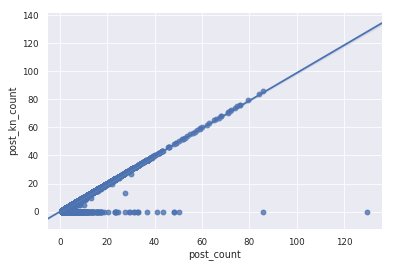

In [84]:
sns.regplot(x="post_count", y="post_kn_count", data=train_user_stat)

In [85]:
%%time
train_user_stat['gw_post_count'] = train_user_stat['post_count'] - train_user_stat['post_kn_count']

CPU times: user 13 ms, sys: 13 ms, total: 26 ms
Wall time: 22.4 ms


In [89]:
%%time
train_user_stat['ratio']= train_user_stat.post_kn_count/train_user_stat.total_pulses

CPU times: user 10 ms, sys: 5 ms, total: 15 ms
Wall time: 12.6 ms


In [95]:
train_user_stat.ratio.fillna(0.0, inplace=True)

In [107]:
train_user_stat.ratio.replace(np.inf, 0, inplace=True)

In [108]:
train_user_stat.mean()

post_count         2.526274
post_kn_count      2.503503
total_pulses     407.122952
gw_post_count      0.022771
ratio              0.022725
dtype: float64

In [109]:
train_user_stat.std()

post_count         2.163736
post_kn_count      2.161080
total_pulses     411.353095
gw_post_count      0.333063
ratio              0.202532
dtype: float64

In [112]:
def ms_large(x, a, b, mean, sd):
    if(x > a*mean):
        return 1 - ((b*sd)/(x - a*mean + b*sd))
    else:
        return 0
    
def calculate_memberships(row):
    width = 0.0
    depth = 0.0
    
    if(row.gw_post_count > 0.0):
        width = ms_large(row.gw_post_count, 0.2, 1, 0.022771, 0.333063)
    
    if(row.ratio > 0.0):
        depth = ms_large(row.gw_post_count, 0.2, 1, 0.022725, 0.202532)
        
    return pd.Series({'width':width, 'depth':depth})

In [113]:
%%time
memberships = train_user_stat.apply(calculate_memberships, axis=1)
train_with_mem = pd.concat([train_user_stat, memberships], axis=1)

CPU times: user 20min 20s, sys: 2min 24s, total: 22min 45s
Wall time: 22min 43s


In [117]:
len(train_with_mem[(train_with_mem.depth>0) & (train_with_mem.width >0)])

5838

In [72]:
top500width = joint_table_1.sort_values(by='width', ascending=False).head(500)

In [119]:
test_user_stat.head()

post_count  post_kn_count  total_pulses
user_id                                         
0                 4            4.0           748
1                 4            4.0          1124
2                 1            1.0           212
3                 1            1.0           875
6                 1            1.0           110

In [120]:
%%time
test_user_stat['gw_post_count'] = test_user_stat['post_count'] - test_user_stat['post_kn_count']
test_user_stat['ratio']= test_user_stat.post_kn_count/test_user_stat.total_pulses

CPU times: user 15 ms, sys: 10 ms, total: 25 ms
Wall time: 21.8 ms


In [121]:
joint_table_1 = train_with_mem.merge(test_user_stat, on='user_id', how='inner')

In [123]:
len(joint_table_1)

369148

In [124]:
joint_table_1.reset_index(inplace=True)

In [125]:
joint_table_1.head()

user_id  post_count_x  post_kn_count_x  total_pulses_x  gw_post_count_x  \
0        0      5.250000         5.125000      564.125000            0.125   
1        1      6.000000         6.000000      896.285714            0.000   
2        2      1.833333         1.833333       99.833333            0.000   
3        3      3.857143         3.857143      715.571429            0.000   
4        6      1.666667         1.666667       84.666667            0.000   

    ratio_x     width     depth  post_count_y  post_kn_count_y  \
0  0.009085  0.265586  0.372941             4              4.0   
1  0.006694  0.000000  0.000000             4              4.0   
2  0.018364  0.000000  0.000000             1              1.0   
3  0.005390  0.000000  0.000000             1              1.0   
4  0.019685  0.000000  0.000000             1              1.0   

   total_pulses_y  gw_post_count_y   ratio_y  
0             748              0.0  0.005348  
1            1124              0.0  0.003559  
2             212              0.0  0.004717  
3             875              0.0  0.001143  
4             110              0.0  0.009091

In [203]:
def InFlowMine(cascade, f, r):
    freq_tab = cascade.groupby(by='user_id').count()
    freq_tab.reset_index(inplace=True)
    fi1 = freq_tab[freq_tab.postid > f]

    fk = {}
    old = set()
    pros = set()
    for n in fi1.user_id.values:
        fk.setdefault(n, set()).add(int(n))
        pros.add(int(n))

    loop = pros.difference(old)
    while(len(loop) > 0):
        pros = set()
        for n in loop:
            old.add(int(n))
            nei = list(followers.setdefault(int(n), set()))
            if(len(nei) == 0):
                continue
            tmp = cascade[cascade.parent_user_id == n]
            tmp = tmp[tmp['user_id'].isin(nei)]
            tmp = tmp.groupby(by='user_id').count()
            f = tmp[tmp.parent_user_id > r].copy()
            if(len(f)>0):        
                for x in f.index.values:
                    fk.setdefault(n, set()).add(int(x))
                    fk.setdefault(x, set()).add(int(x))            
                    pros.add(int(x))
        loop = pros.difference(old)
    return fk


def NDIF(fk, k):
    V = []
    Vs = set()
    total = set()
    while len(V) < k:
        if(len(V)%100 == 0):
            print(len(V))
        l = 0
        j = -1
        for x in fk:
            if x in Vs:
                continue
            tl = len(total.union(fk[x]))
            if(tl > l):
                l = tl
                j = x

        if(j != -1):
            V.append(j)
            Vs.add(j)
            total = total.union(fk[j])
        else:
            break
    
    return pd.DataFrame(V, columns=['node'])

In [177]:
retweet2011.sort_values(by='month', inplace=True)

In [189]:
x = retweet2011.groupby(by='user_id').count()

In [77]:
len(followers)

1775214

In [193]:
%%time
fkl = InFlowMine(retweet2011[retweet2011.month < 12], 20, 5)

CPU times: user 48min 17s, sys: 56 s, total: 49min 13s
Wall time: 49min 12s


In [194]:
#save_obj(fkl, "in_flow_25_10")
#save_obj(fkl, "in_flow_20_5")

In [204]:
%%time
topk1 = NDIF(fkl, 500)

0
100
200
300
400
CPU times: user 10h 18min 6s, sys: 21min 5s, total: 10h 39min 11s
Wall time: 10h 39min 8s


In [207]:
#topk1.to_csv('datasets/Weibo/ndif_top500.csv')

In [69]:
topk1 = pd.read_csv('datasets/Weibo/ndif_top500.csv', index_col=0)

In [78]:
%%time
deg = []
for key in followers:
    deg.append((key, len(followers[key])))

CPU times: user 3.67 s, sys: 2.41 s, total: 6.09 s
Wall time: 6.09 s


In [79]:
%%time
deg = sorted(deg, key=lambda ele: ele[1], reverse=True)
degx = pd.DataFrame([[int(x[0]), int(x[1])] for x in deg], columns=['node', 'degree'])

CPU times: user 2min 13s, sys: 1min 27s, total: 3min 40s
Wall time: 3min 39s


In [152]:
%%time
dif_deg = []
for key, val in followers.items():
    dd = len(val)*0.1
    for k in val:
        try:
            dd = dd + 0.1*len(followers[k])
        except KeyError:
            continue
        
    dif_deg.append((key, dd))

CPU times: user 11min 14s, sys: 26.2 s, total: 11min 40s
Wall time: 11min 40s


In [160]:
def degree_discount(d, k, p):
    degdis = d.copy()
    degdis['dd'] = degdis.degree
    degdis['tv'] = 0

    data = set()
    for i in range(k):
        node = degdis.sort_values(by='dd', ascending=False).node.values[i]
        
        try:
            nei = following[node]
    
            for n in nei:
                n = int(n)
                if (n in data):
                    #print(n)
                    continue
                n_row = degdis.index[degdis.node == n]

                r = degdis[degdis.node == n]
                tv = r.tv.values[0] + 1
                degdis.at[n_row, 'tv'] = tv
                degdis.at[n_row, 'dd'] = r.degree.values[0] - 2*tv - (r.degree.values[0] - tv)*tv*p
        except KeyError:
            print(node)
        data.add(node)
    
    return degdis.sort_values(by='dd', ascending=False).head(k)

In [161]:
%%time 

'''Degree Discount'''
ddis_topk = degree_discount(degx, 500, 0.1)

509100
834641
1328662
902509
502814
1138207
255243
234340
1404363
1238936
156243
645747
495820
CPU times: user 1h 39min 15s, sys: 6min 42s, total: 1h 45min 57s
Wall time: 1h 45min 57s


In [163]:
#ddis_topk.to_csv('datasets/Weibo/ddis_topk.csv')

In [82]:
ddis_topk = pd.read_csv('datasets/Weibo/ddis_topk.csv', index_col=0)

In [165]:
dd_base = pd.DataFrame([[int(x[0]), int(x[1])] for x in deg_dis], columns=['node', 'degree'])

In [166]:
dd_base.sort_values(by='degree', inplace=True, ascending=False)

In [167]:
dd_topk = dd_base.head(500)

In [171]:
top500width.reset_index(inplace=True)

In [172]:
top500width.head()

user_id  post_count  post_kn_count  total_pulses  gw_post_count  ratio  \
0   490872  129.636364            0.0    741.727273     129.636364    0.0   
1   519514   86.000000            0.0    681.818182      86.000000    0.0   
2   244531   50.090909            0.0   2043.272727      50.090909    0.0   
3   836276   48.181818            0.0    295.909091      48.181818    0.0   
4   908988   48.000000            0.0    717.000000      48.000000    0.0   

      width  depth  
0  0.997437    0.0  
1  0.996142    0.0  
2  0.993394    0.0  
3  0.993134    0.0  
4  0.993108    0.0

CPU times: user 13.1 s, sys: 201 ms, total: 13.3 s
Wall time: 13.3 s


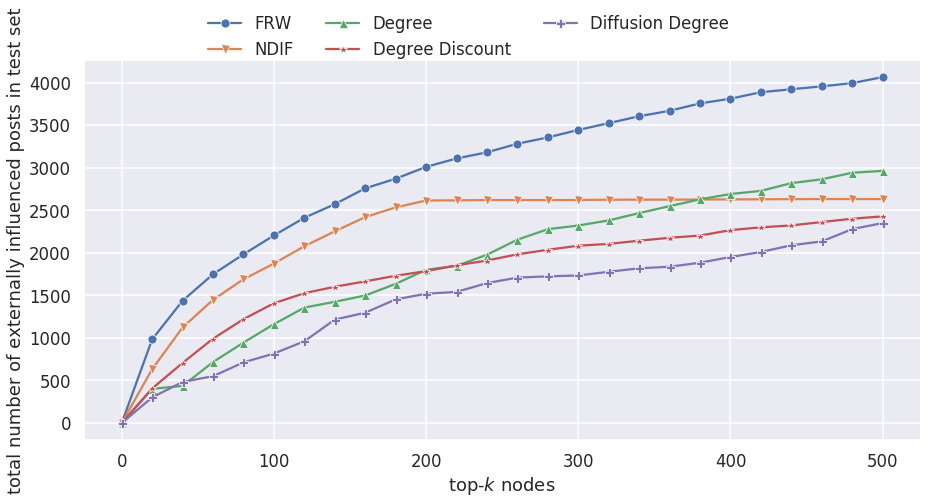

In [90]:
%%time
data = []
for i in range(0, 501, 20):
    ndif = topk1.head(i)
    pot = top500width.head(i)
    d = degx.head(i)
    ddis = ddis_topk.head(i)
    dd = dd_topk.head(i)
    #xx = top500x.head(i)
    
    ndif_t = joint_table_1.merge(ndif, left_on='user_id', right_on='node', how='inner').gw_post_count_y.sum()
    d_t = joint_table_1.merge(d, left_on='user_id', right_on='node', how='inner').gw_post_count_y.sum()
    ddis_t = joint_table_1.merge(ddis, left_on='user_id', right_on='node', how='inner').gw_post_count_y.sum()
    dd_t = joint_table_1.merge(dd, left_on='user_id', right_on='node', how='inner').gw_post_count_y.sum()
    pot_t = pot.gw_post_count_y.sum()#joint_table_1.merge(pot, left_on='user_id', right_on='user_id', how='inner').gw_post_count_y.sum()
    #xx_t = joint_table_1.merge(xx, left_on='user_id', right_on='user_id', how='inner').gw_post_count_y.sum()
        
    data.append([i, pot_t, 'FRW'])
    data.append([i, ndif_t, 'NDIF'])    
    data.append([i, d_t, 'Degree'])
    data.append([i, ddis_t, 'Degree Discount'])
    data.append([i, dd_t, 'Difusion Degree'])
    #data.append([i, xx_t, 'X'])

plot_data = pd.DataFrame(data, columns=['seed', 'value', 'Algorithm'])

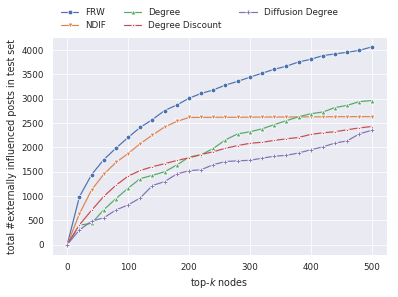

In [93]:
fig, ax = plt.subplots()

sns.set_context("paper")
sns.lineplot(data=plot_data, x='seed', y='value', dashes=False, hue='Algorithm', style='Algorithm', markers=['o', 'v', '^', '*', 'P', 'X'], legend=False)
ax.set(xlabel='top-$k$ nodes', ylabel='total #externally influenced posts in test set')
ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['FRW','NDIF','Degree', 'Degree Discount', 'Diffusion Degree', 'X'])

fig.savefig("graphics/weibo_FRW_compare.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')